## Importing and prepping data

In [1]:
import pandas as pd

import diff_classifier.aws as aws
import diff_classifier.pca as pca

import os
import diff_classifier.imagej as ij
import boto3
import os.path as op
import diff_classifier.aws as aws
import diff_classifier.knotlets as kn
import numpy as np
from sklearn.externals import joblib

In [2]:
features = []
#featofvar = 'Type and Serum'

remote_folder = 'Cell_Studies/10_16_18_cell_study' #Folder in AWS S3 containing files to be analyzed
bucket = 'ccurtis.data'
vids = 5
types = ['PS', 'PEG']
slices = [1, 2]
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1']

counter = 0
for typ in types:
    for slic in slices:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}_XY{}.csv'.format(typ, slic, num)
                print(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1")
                
                for extra in extras:
                    fstats[extra] = fstats.index
                fstats = fstats.drop(extras, axis=1)
                
                print('{} size: {}'.format(filename, fstats.shape))
                if 'PS' in typ:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['COOH'], index=fstats.index)
                else:
                    fstats['Type'] = pd.Series(fstats.shape[0]*['PEG'], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                fstats['Well Number'] = pd.Series(fstats.shape[0]*[slic], index=fstats.index)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('Skipped!: {}'.format(filename))

features_PS_1_XY1.csv
features_PS_1_XY1.csv size: (17215, 72)
features_PS_1_XY2.csv
features_PS_1_XY2.csv size: (36025, 72)
features_PS_1_XY3.csv
features_PS_1_XY3.csv size: (27995, 72)
features_PS_1_XY4.csv
features_PS_1_XY4.csv size: (31375, 72)
features_PS_1_XY5.csv
features_PS_1_XY5.csv size: (25037, 72)
features_PS_2_XY1.csv
features_PS_2_XY1.csv size: (13730, 72)
features_PS_2_XY2.csv
features_PS_2_XY2.csv size: (10992, 72)
features_PS_2_XY3.csv
features_PS_2_XY3.csv size: (18088, 72)
features_PS_2_XY4.csv
features_PS_2_XY4.csv size: (27814, 72)
features_PS_2_XY5.csv
features_PS_2_XY5.csv size: (21126, 72)
features_PEG_1_XY1.csv
features_PEG_1_XY1.csv size: (14422, 73)
features_PEG_1_XY2.csv
features_PEG_1_XY2.csv size: (10203, 72)
features_PEG_1_XY3.csv
features_PEG_1_XY3.csv size: (12272, 72)
features_PEG_1_XY4.csv
features_PEG_1_XY4.csv size: (15135, 72)
features_PEG_1_XY5.csv
features_PEG_1_XY5.csv size: (14631, 72)
features_PEG_2_XY1.csv
features_PEG_2_XY1.csv size: (12991, 

In [ ]:
fstats.columns

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [ ]:
fstats_tot['Type'].unique()

In [3]:
for typ in fstats_tot['Type'].unique():
    fstats_type = fstats_tot[fstats_tot['Type']==typ].reset_index(drop=True)
    print(fstats_type.shape)

(229397, 76)
(132788, 76)


In [4]:
#with equal sample sizes for each particle type
nonnum = ['Type', 'Well Number', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y', 'Cell Status', 'Cell Distance', 'Membrane Xing', 'Distance Towards Cell',
          'Percent Towards Cell']

import random
counter = 0
for typ in fstats_tot['Type'].unique():
    fstats_type = fstats_tot[fstats_tot['Type']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 100000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(229397, 76)
(132788, 76)


In [5]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [6]:
ncomp = 13
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.35173226430636817
1 component: 0.4610687597626145
2 component: 0.5324661278193117
3 component: 0.5830556445739938
4 component: 0.6193560333007351
5 component: 0.6547464522110387
6 component: 0.6836617895102782
7 component: 0.7082533769748046
8 component: 0.7299834222123139
9 component: 0.7506304444661972
10 component: 0.7686403100593451
11 component: 0.7855752826309852
12 component: 0.8022918960674432


In [ ]:
pcadataset.components.to_csv('components.csv')

In [ ]:
fstats_num.columns

In [7]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Mean straightness,asymmetry3,asymmetry2,Mean SN_Ratio,boundedness,Std elongation,straightness,D_fit,Std AR,kurtosis,Std Deff2,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1
1,Mean efficiency,Mean asymmetry1,asymmetry1,SN_Ratio,trappedness,Std asymmetry3,D_fit,Std MSD_ratio,Mean AR,D_fit,Mean Deff2,Std Deff2,Std straightness
2,Mean Deff1,Mean asymmetry2,efficiency,Std asymmetry1,alpha,Std asymmetry2,efficiency,boundedness,Std MSD_ratio,Deff1,Deff2,Deff2,Mean alpha
3,Mean D_fit,asymmetry2,asymmetry3,Mean elongation,MSD_ratio,Std asymmetry1,alpha,trappedness,Mean MSD_ratio,Deff2,Std MSD_ratio,Quality,kurtosis
4,Mean fractal_dim,elongation,elongation,Quality,asymmetry2,Std straightness,boundedness,Mean MSD_ratio,SN_Ratio,Std AR,kurtosis,kurtosis,Std alpha


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [ ]:
kmostat = pca.kmo(pcadataset.scaled)

In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [8]:
import numpy as np
featofvar = 'Type'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG'].values[:, -ncomp:], axis=0)

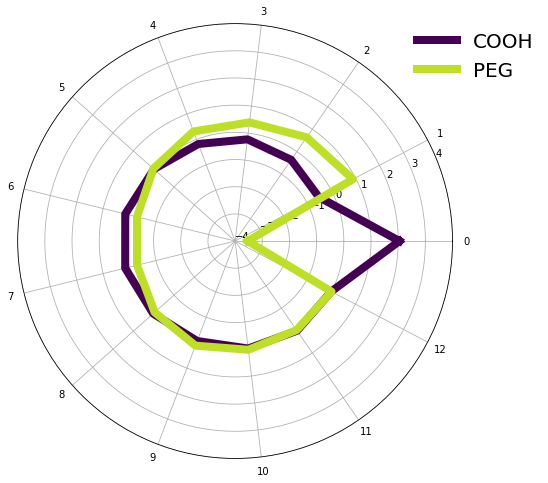

In [9]:
labels = ['COOH', 'PEG']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9))

In [45]:
pcadataset.final = pcadataset.final[[pcadataset.final.columns[-1]] + list(pcadataset.final.columns[0:-1])]

In [47]:
import numpy as np
#featofvar = 'Type'
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG False'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH False'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='PEG True'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final[featofvar]=='COOH True'].values[:, -ncomp:], axis=0)

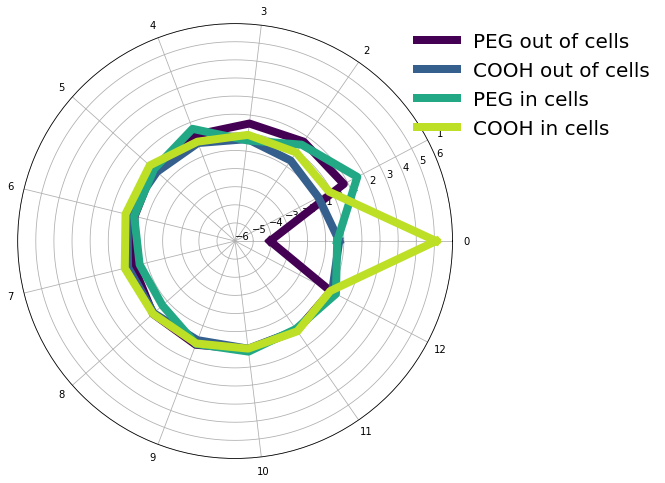

In [48]:
labels2 = ['PEG out of cells', 'COOH out of cells', 'PEG in cells', 'COOH in cells']
pca.plot_pca(dicti, savefig=True, labels=labels2, rticks=np.linspace(-6, 6, 13))

In [14]:
import diff_classifier.heatmaps as hm
import matplotlib.pyplot as plt

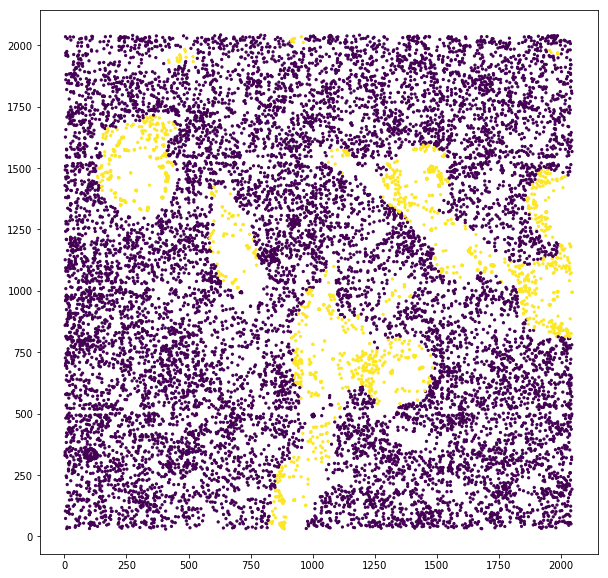

In [16]:
substats = pcadataset.final[(pcadataset.final['Video Number']==1) & (pcadataset.final['Well Number']==1) &
                            (pcadataset.final['Type']=='PEG')]
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(substats['X'], substats['Y'], c=substats['Cell Status'], s=5)
plt.show()

In [27]:
pcadataset.final['Type and Cell'] = pcadataset.final['Type'] + ' ' + pcadataset.final['Cell Status'].map(str)

In [30]:
pcadataset.final.head()

,AR,Cell Distance,Cell Status,D_fit,Deff1,Deff2,Distance Towards Cell,MSD_ratio,Mean AR,Mean D_fit,...,4,5,6,7,8,9,10,11,12,Type and Cell
0,inf,15.652476,False,10.314264,0.741668,0.048527,465.509973,1.620999,inf,4.678733,...,-0.118639,-2.696001,2.679505,0.048787,-2.554943,0.105208,0.218558,-0.151025,0.489511,COOH False
1,inf,14.142136,True,0.000553,0.001209,0.000132,0.000000,0.098613,inf,4.678733,...,-1.872558,-1.772146,2.885986,-0.337217,-3.615841,1.226610,0.663926,0.554361,-0.565704,COOH True
2,1.928077,487.811439,False,0.047405,6.873934,NaN,-10.337097,-0.010986,1.965460,21.464435,...,-0.750112,1.614176,-0.819727,-0.884071,1.172656,0.931647,0.964504,-0.825729,2.493220,COOH False
3,2.257721,396.415186,False,6.737007,8.136570,NaN,0.000000,0.014778,2.001582,14.990403,...,0.172894,0.208045,-0.025478,0.428149,-0.484075,0.543699,-0.809825,0.169193,-0.621931,COOH False
4,inf,35.355339,True,4.119282,1.279609,NaN,443.930337,0.161808,inf,4.678733,...,-0.247595,-2.762154,1.697510,0.503222,-2.062515,-0.694144,0.506524,-0.090292,0.528345,COOH True


The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

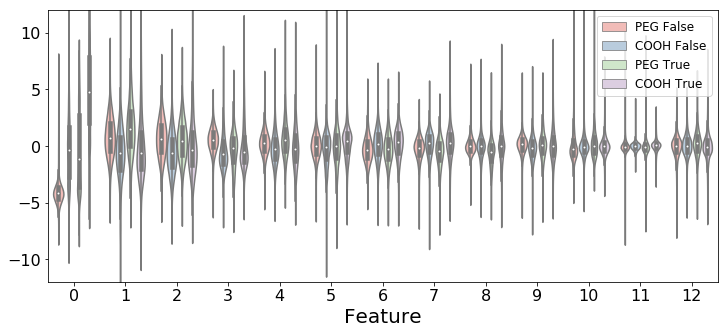

In [32]:
labels=['PEG False', 'COOH False', 'PEG True', 'COOH True']
featofvar = 'Type and Cell'
feats = pca.feature_violin(pcadataset.final, label=featofvar, lvals=labels, fsubset=ncomp, yrange=[-12, 12])

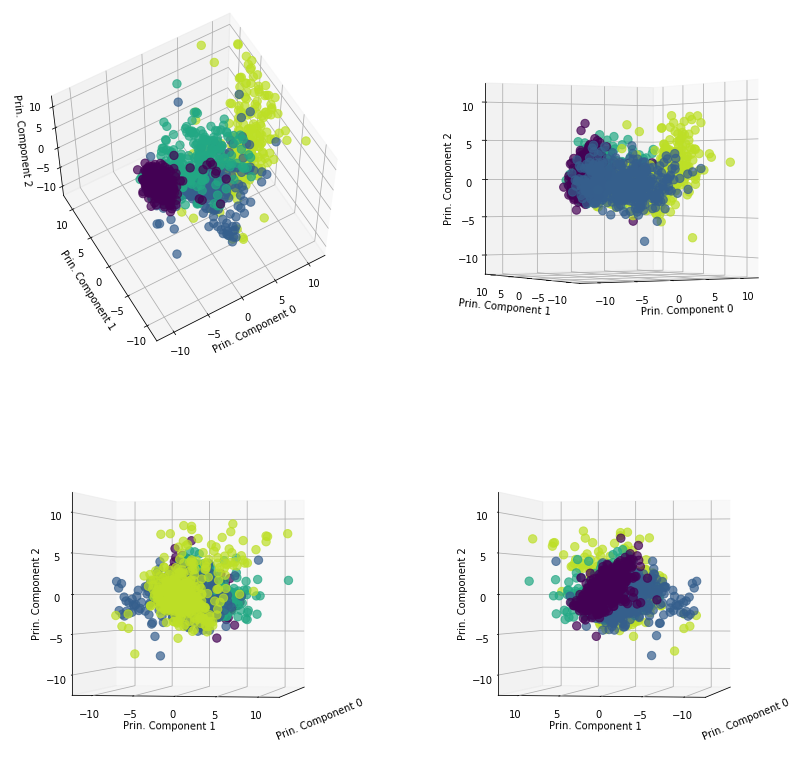

In [33]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label=featofvar, lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

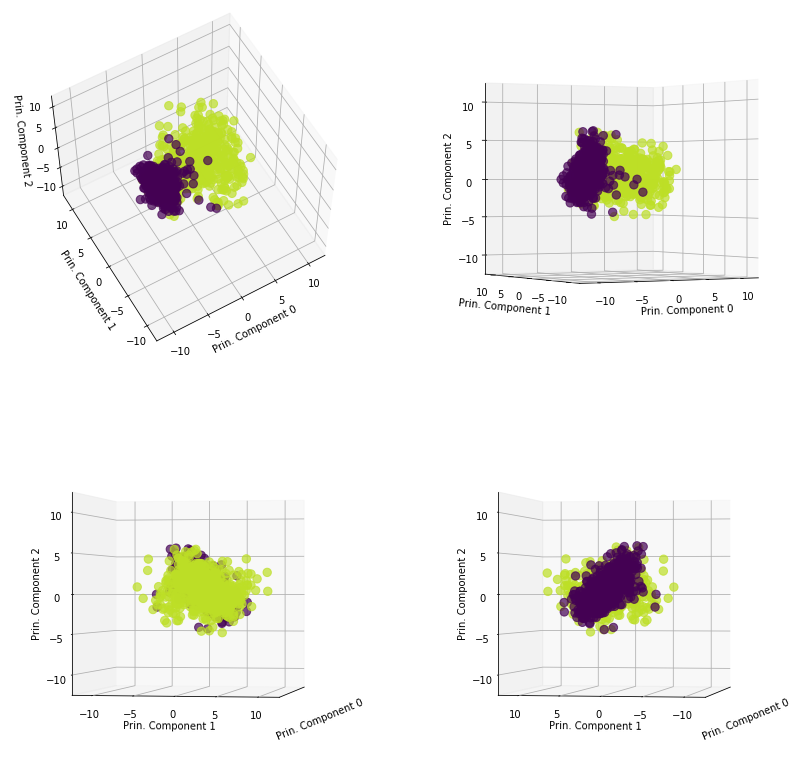

In [56]:
labels1 = ['PEG False', 'PEG True']
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final['Type']=='PEG'], label=featofvar, lvals=labels1, randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

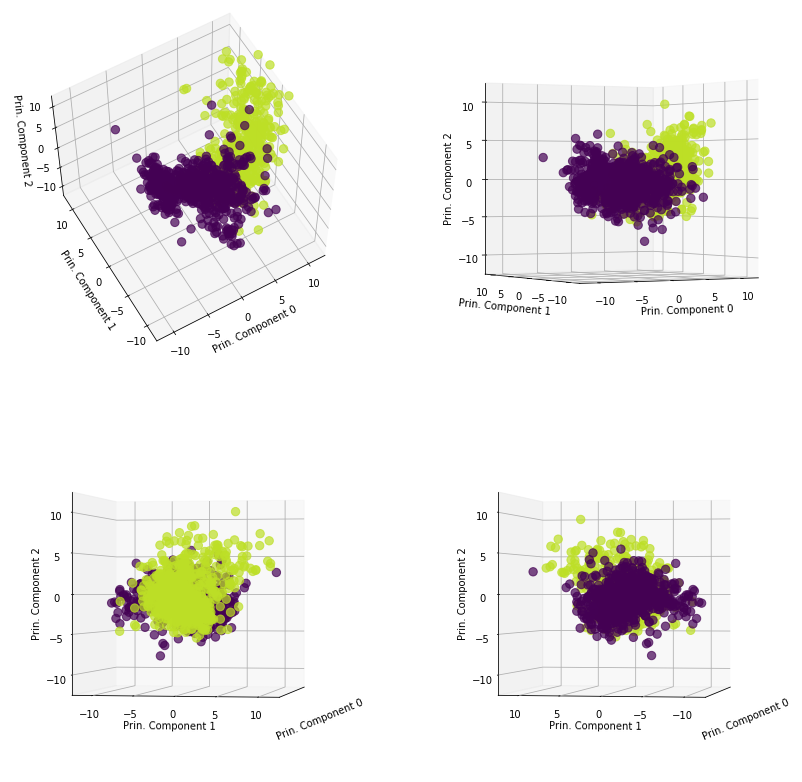

In [57]:
labels1 = ['COOH False', 'COOH True']
fstats1 = pca.feature_plot_3D(pcadataset.final[pcadataset.final['Type']=='COOH'], label=featofvar, lvals=labels1, randcount=800, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12])

In [80]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, featofvar, labels, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final[featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.7205765009594545
Run 1: 0.7146789624087138
Run 2: 0.7424824330107542
Run 3: 0.7505004348606376
Run 4: 0.7189723483854936
Run 5: 0.7234148294379944
Run 6: 0.7374242445159241
Run 7: 0.7315846873835194
Run 8: 0.7017877603986913
Run 9: 0.7277358256139818
Run 10: 0.7236771263304664
Run 11: 0.7153084749506468
Run 12: 0.7194610489114679
Run 13: 0.7185057360188853
Run 14: 0.7198475917003742
Run 15: 0.7187128125129423
Run 16: 0.7293316951281803
Run 17: 0.7193009097560639
Run 18: 0.76419233264768
Run 19: 0.7245385645457432


In [59]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.7209125 +/ 0.009931098567127403
0.7256744481411432 +/ 0.015468561667528205


In [85]:
#ncomp = 14
labels1 = ['COOH False', 'COOH True']
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final[pcadataset.final[featofvar].isin(labels1)], featofvar, labels1, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(10, 6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)].values[:, -ncomp:]
    y2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)][featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.8298452028579275
Run 1: 0.8421339424665536
Run 2: 0.8239907235055385
Run 3: 0.81425214802286
Run 4: 0.8321468894536546
Run 5: 0.823336835268116
Run 6: 0.8342436910683226
Run 7: 0.8290387406984399
Run 8: 0.8300893211332319
Run 9: 0.8294267143859771


In [86]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.87965 +/ 0.013309864762648794
0.8288504208860621 +/ 0.00697440974552204


In [87]:
#ncomp = 14
labels1 = ['PEG False', 'PEG True']
trainp = np.array([])
testp = np.array([])
#labels3 = ['low', 'hi']

for i in range(0, 10):
    KNNmod, X, y = pca.build_model(pcadataset.final[pcadataset.final[featofvar].isin(labels1)], featofvar, labels1, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(10, 6, 5, 3))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)].values[:, -ncomp:]
    y2 = pcadataset.final[pcadataset.final[featofvar].isin(labels1)][featofvar].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.805148055547188
Run 1: 0.768367623580444
Run 2: 0.7277464831159443
Run 3: 0.8065261921257945
Run 4: 0.8095008585113113
Run 5: 0.861139560803687
Run 6: 0.8667725999337289
Run 7: 0.8488568244118444
Run 8: 0.8056902732174595
Run 9: 0.7257056360514504


In [88]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.8363999999999999 +/ 0.012012077255828814
0.8025454107298853 +/ 0.04738290173348691


In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
def build_modelR(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'NNsolver': 'adam', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                }

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'MLP':
        clf = MLPRegressor(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'],
                            beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'],
                            epsilon=kwargs['epsilon'])
    
        clf.fit(X, y)
        return clf, X, y

In [ ]:
labels2 = [0.4, 0.6, 0.8, 1.0, 1.2]

trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Bulk Agarose Int', labels2, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y2, MLPmod.predict(X2), alpha=0.002)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y, MLPmod.predict(X), alpha=0.006)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
plt.xticks(labels2)
plt.yticks(ticks)

In [ ]:
labelshort = [0.4, 0.6, 0.8, 1.0]
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose Int'].isin(labelshort)]
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcasub, 'Bulk Agarose Int', labelshort, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

In [ ]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

In [ ]:
combos = [['0_8', '1_0']]
vids = 5

counter = 0
for combo in combos:
    for num in range(1, vids+1):

        filename = 'features_100x_{}_{}_gel_interface_vid_{}.csv'.format(combo[0], combo[1], num)
        aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
        fstats_new1 = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        #fstats['Percent Agarose'] = pd.Series(fstats.shape[0]*[str(visc[key])], index=fstats.index)
        #print(fstats_new.shape[0])
        fstats_new1['Video Number'] = pd.Series(fstats_new1.shape[0]*[num], index=fstats_new1.index)
        fstats_new1['Interface'] = pd.Series(fstats_new1.shape[0]*['{}/{}'.format(combo[0], combo[1])], index=fstats_new1.index)
        #print(num)
        print(filename)
        counter = counter + 1
        if counter == 1:
            fstats_tot1 = fstats_new1
        else:
            fstats_tot1 = fstats_tot1.append(fstats_new1, ignore_index=True)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '1_2'], legendloc=2)

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=2
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_4', '0_8'], legendloc=2)

In [ ]:
from matplotlib.pyplot import cm
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=3
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_6', '0_8'])

In [ ]:
nonnum1 = ['Interface', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y']
fstats_num1 = fstats_tot1.drop(nonnum1, axis=1)
interf_data = pca.recycle_pcamodel(pcadataset.pcamodel, fstats_num1)
interf_data['Predicted'] = KNNmod.predict(interf_data[list(range(0, ncomp))])

for col in nonnum1:
    interf_data[col] = fstats_tot1[col]

num=4
rearr = feature_plot_2D(interf_data[interf_data['Video Number']==num],
                            label='Predicted', features=['X', 'Y'], randsel=False, dotsize=10,
                            lvals=['0_8', '1_0'])

In [ ]:
def feature_plot_2D(dataset, label, features=[0, 1], lvals=['PEG', 'PS'],
                    randsel=True, randcount=200, **kwargs):

    defaults = {'figsize': (8, 8), 'dotsize': 70, 'alpha': 0.7, 'xlim': None,
                'ylim': None, 'legendfontsize': 12, 'labelfontsize': 20,
                'fname': None, 'legendloc': 2}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    tgroups = {}
    xy = {}
    counter = 0
    labels = dataset[label].unique()
    for lval in lvals:
        tgroups[counter] = dataset[dataset[label] == lval]
        counter = counter + 1

    N = len(tgroups)
    color = iter(cm.viridis(np.linspace(0, 0.9, N)))

    fig = plt.figure(figsize=kwargs['figsize'])
    ax1 = fig.add_subplot(111)
    counter = 0
    for key in tgroups:
        c = next(color)
        xy = []
        if randsel:
            to_plot = random.sample(range(0, len(tgroups[key][0].tolist())),
                                    randcount)
            for key2 in features:
                xy.append(list(tgroups[key][key2].tolist()[i] for i in to_plot))
        else:
            for key2 in features:
                xy.append(tgroups[key][key2])
        ax1 = plt.scatter(xy[0], xy[1], c=c, s=kwargs['dotsize'],
                          alpha=kwargs['alpha'], label=labels[counter])
        counter = counter + 1

    if kwargs['xlim'] is not None:
        plt.xlim(kwargs['xlim'])
    if kwargs['ylim'] is not None:
        plt.ylim(kwargs['ylim'])

    plt.legend(fontsize=kwargs['legendfontsize'], frameon=False,
               borderaxespad=0., loc=2,
               bbox_to_anchor=(1, 1))
    plt.xlabel('Prin. Component {}'.format(features[0]),
               fontsize=kwargs['labelfontsize'])
    plt.ylabel('Prin. Component {}'.format(features[1]),
               fontsize=kwargs['labelfontsize'])

    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'])

    return xy

In [142]:
prefix = 'PEG_2_XY1'
ffilename = 'features_{}.csv'.format(prefix)
mfilename = 'msd_{}.csv'.format(prefix)
extras = ['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1',
          'Unnamed: 0.1.1.1.1.1']

fstats = pd.read_csv(ffilename, encoding = "ISO-8859-1")     
for extra in extras:
    fstats[extra] = fstats.index
fstats = fstats.drop(extras, axis=1)

msds = pd.read_csv(mfilename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
for extra in extras:
    msds[extra] = msds.index
msds = msds.drop(extras, axis=1)

/home/ubuntu/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [143]:
fstats.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Std SN_Ratio,Mean Deff1,Std Deff1,Mean Deff2,Std Deff2,Cell Status,Cell Distance,Membrane Xing,Distance Towards Cell,Percent Towards Cell
0,0.0,1.374795,0.976583,2.349847,0.394587,0.477890,0.064436,1.453592,0.312049,0.057962,...,0.232009,8.492230,4.996041,6.991858,0.000000,False,119.016806,0,553.156853,0.032308
1,1.0,1.165547,8.167996,2.564467,0.825139,0.219121,0.229586,2.128126,0.530103,0.025642,...,0.232009,8.492230,4.996041,6.991858,0.000000,False,196.400102,0,490.702972,0.029231
2,2.0,0.513771,35.302978,1.543124,0.942410,0.121769,0.365954,2.051652,0.512588,0.035699,...,0.149640,8.415536,3.825599,5.690404,2.767559,False,377.637392,0,295.956473,0.024615
3,3.0,0.483646,14.322564,2.048341,0.776654,0.251209,0.197321,1.444153,0.307552,0.040751,...,0.112913,8.530975,4.666081,NaN,NaN,False,103.788246,0,567.970457,0.056923
4,4.0,2.964716,0.005122,3.869682,0.812323,0.227855,0.220311,2.352566,0.574932,0.035296,...,0.149640,8.415536,3.825599,5.690404,2.767559,False,444.086703,0,226.756619,0.038462


In [144]:
msds.head()

,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity,Cell Status,Cell Distance
0,0.0,0.0,505.961893,1804.692451,0.000000,0.000000,6.358765,1.268822,564.896907,False,120.917327
1,1.0,0.0,505.391703,1799.385593,29.860717,0.528082,7.333496,0.909511,563.350515,False,117.456375
2,2.0,0.0,502.839351,1795.752834,60.613298,0.614971,7.563232,1.174019,566.762887,False,117.034183
3,3.0,0.0,500.814121,1794.617848,90.272830,0.781139,19.808228,1.280540,607.587629,False,117.923704
4,4.0,0.0,503.450024,1790.464504,117.742161,0.726269,28.938171,1.087979,638.072165,False,113.070774


In [107]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=200))]

In [145]:
import matplotlib.cm as cm
import matplotlib as mpl

Text(0,0.5,'Mean Squared Displacement ($\\mu$m$^2$)')

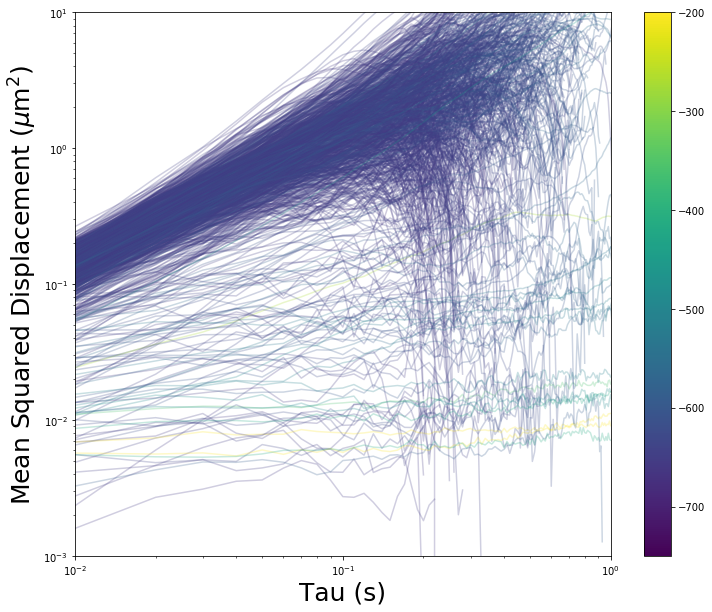

In [157]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==False]['Track_ID'].unique().tolist(), k=1000))]
t_min, t_max = -750, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

Text(0,0.5,'Mean Squared Displacement ($\\mu$m$^2$)')

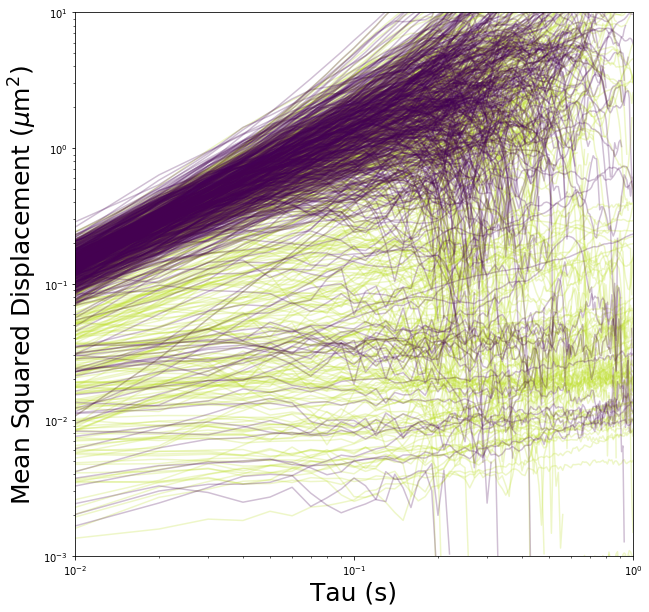

In [153]:
sample1 = msds[msds['Track_ID'].isin(random.sample(msds[(msds['Cell Status']==False)]['Track_ID'].unique().tolist(), k=500))]
sample2 = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
fig, ax = plt.subplots(figsize=(10, 10))

t_min, t_max = 0, 1
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

for i in sample2.Track_ID.unique():
    ax.plot(sample2[sample2.Track_ID==i].Frame/100.02, sample2[sample2.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0.9), alpha=0.25)

for i in sample1.Track_ID.unique():
    ax.plot(sample1[sample1.Track_ID==i].Frame/100.02, sample1[sample1.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(0), alpha=0.25)

plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)

Text(0,0.5,'Mean Squared Displacement ($\\mu$m$^2$)')

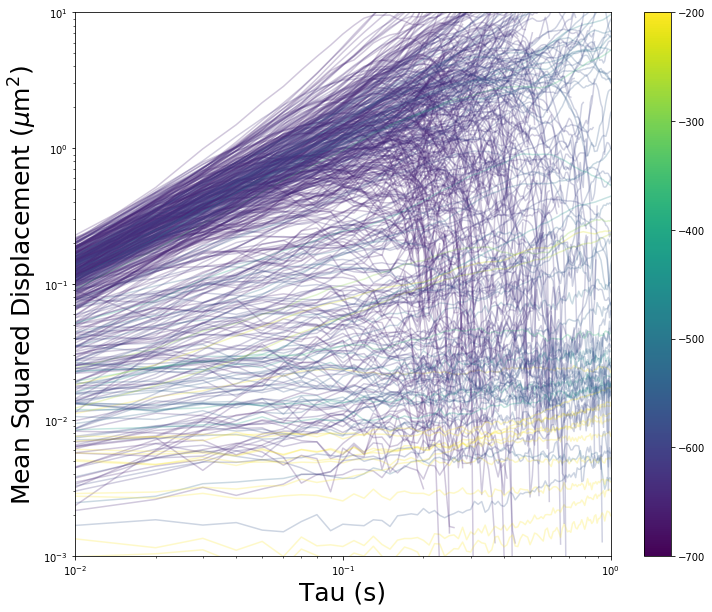

In [160]:
sample = msds[msds['Track_ID'].isin(random.sample(msds[msds['Cell Status']==True]['Track_ID'].unique().tolist(), k=500))]
t_min, t_max = -700, -200
fig, ax = plt.subplots(figsize=(12, 10))
norm = mpl.colors.Normalize(t_min, t_max, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
    
for i in sample.Track_ID.unique():
    ax.plot(sample[sample.Track_ID==i].Frame/100.02, sample[sample.Track_ID==i].MSDs*.07*.07,
            c=mapper.to_rgba(-sample[sample.Track_ID==i]['Cell Distance'].mean()), alpha=0.25)
    #print(sample[sample.Track_ID==i]['Cell Distance'].mean())

mapper.set_array(20)
plt.loglog()
ax.set_xlim(10**-2, 1)
ax.set_ylim(10**-3, 10*1)
plt.colorbar(mapper)
plt.xlabel('Tau (s)', fontsize=25)
plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)